In [21]:
from moseq2_detectron_extract.io.session import Session
import matplotlib.pyplot as plt
import numpy as np
import cv2

from moseq2_detectron_extract.proc.proc import prep_raw_frames, clean_frames, get_frame_features
from skimage.morphology import medial_axis, skeletonize


In [2]:
session = Session(r"D:\moseq-extract-testing\test_2animal_full_timecourse\20MOS08-F\session_20200824122748.tar.gz")
first_frame, bground_im, roi, true_depth = session.find_roi()

In [48]:
def plot_frames(frames, idxs, cols=5, fig_size=(20,20), vmin=0, vmax=100, features=None):
    cols = int(cols)
    rows = int(np.ceil(frames.shape[0] / cols))
    fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=fig_size)
    
    for i, ax in enumerate(axs.flat):
        ax.imshow(frames[i], vmin=vmin, vmax=vmax)
        if features is not None:
            feat = features[i]
            # draw the centroid as a point
            ax.scatter(feat['centroid'][0], feat['centroid'][1], c='r')
            # draw the orientation as an arrow
            r = 5
            dx = r * np.cos(feat['orientation'])
            dy = r * np.sin(feat['orientation'])
            ax.arrow(feat['centroid'][0], feat['centroid'][1], dx, dy, width=5)
        ax.set_title(idxs[i])
    fig.tight_layout()
    
def plot_contours(frames, contours, idxs, cols=5, fig_size=(20,20), vmin=0, vmax=100):
    cols = int(cols)
    rows = int(np.ceil(frames.shape[0] / cols))
    fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=fig_size)
    norm = plt.Normalize(vmin, vmax)
    cmap = plt.get_cmap('jet')
    
    disp_img = frames.copy().astype('float32')
    disp_img = (disp_img-vmin)/(vmax-vmin)
    disp_img[disp_img < 0] = 0
    disp_img[disp_img > 1] = 1
    disp_img = cmap(disp_img)[:,:,:,:3]*255
    
    for i, ax in enumerate(axs.flat):
        cv2.drawContours(disp_img[i], [contours[i]], -1, (0,255,255), 1)
        ax.imshow(disp_img[i])
        ax.set_title(idxs[i])
    fig.tight_layout()

def im_moment_features(IM: np.ndarray) -> dict:
    ''' Use the method of moments and centralized moments to get image properties

    Parameters:
    IM (2d numpy array): depth image

    Returns:
    Features (dictionary): returns a dictionary with orientation,
    centroid, and ellipse axis length
    '''

    tmp = cv2.moments(IM)
    num = 2*tmp['mu11']
    den = tmp['mu20']-tmp['mu02']

    common = np.sqrt(4*np.square(tmp['mu11'])+np.square(den))

    if tmp['m00'] == 0:
        features = {
            'orientation': np.nan,
            'centroid': np.nan,
            'axis_length': [np.nan, np.nan]
        }
    else:
        features = {
            'orientation': -.5*np.arctan2(num, den),
            'centroid': [tmp['m10']/tmp['m00'], tmp['m01']/tmp['m00']],
            'axis_length': [2*np.sqrt(2)*np.sqrt((tmp['mu20']+tmp['mu02']+common)/tmp['m00']),
                            2*np.sqrt(2)*np.sqrt((tmp['mu20']+tmp['mu02']-common)/tmp['m00'])]
        }

    return features

def lin_regress_orientation(IM: np.ndarray):
    points = np.nonzero(IM) # row, col order
    model = np.polyfit(points[1], points[0], 1)
    orientation = np.arctan(model[0])
    return orientation
    

In [6]:
frames_of_interest = range(18520, 18545)
frame_idxs, raw_frames = next(session.index(frames_of_interest))
raw_frames = prep_raw_frames(raw_frames, bground_im=bground_im, roi=roi, vmin=0, vmax=100)

In [24]:
cleaned_frames = clean_frames(raw_frames, iters_tail=3, prefilter_time=(3,))
features, masks = get_frame_features(cleaned_frames, progress_bar=False, use_cc=True, frame_threshold=3)

Cleaning frames: 100%|███████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 3333.15it/s]


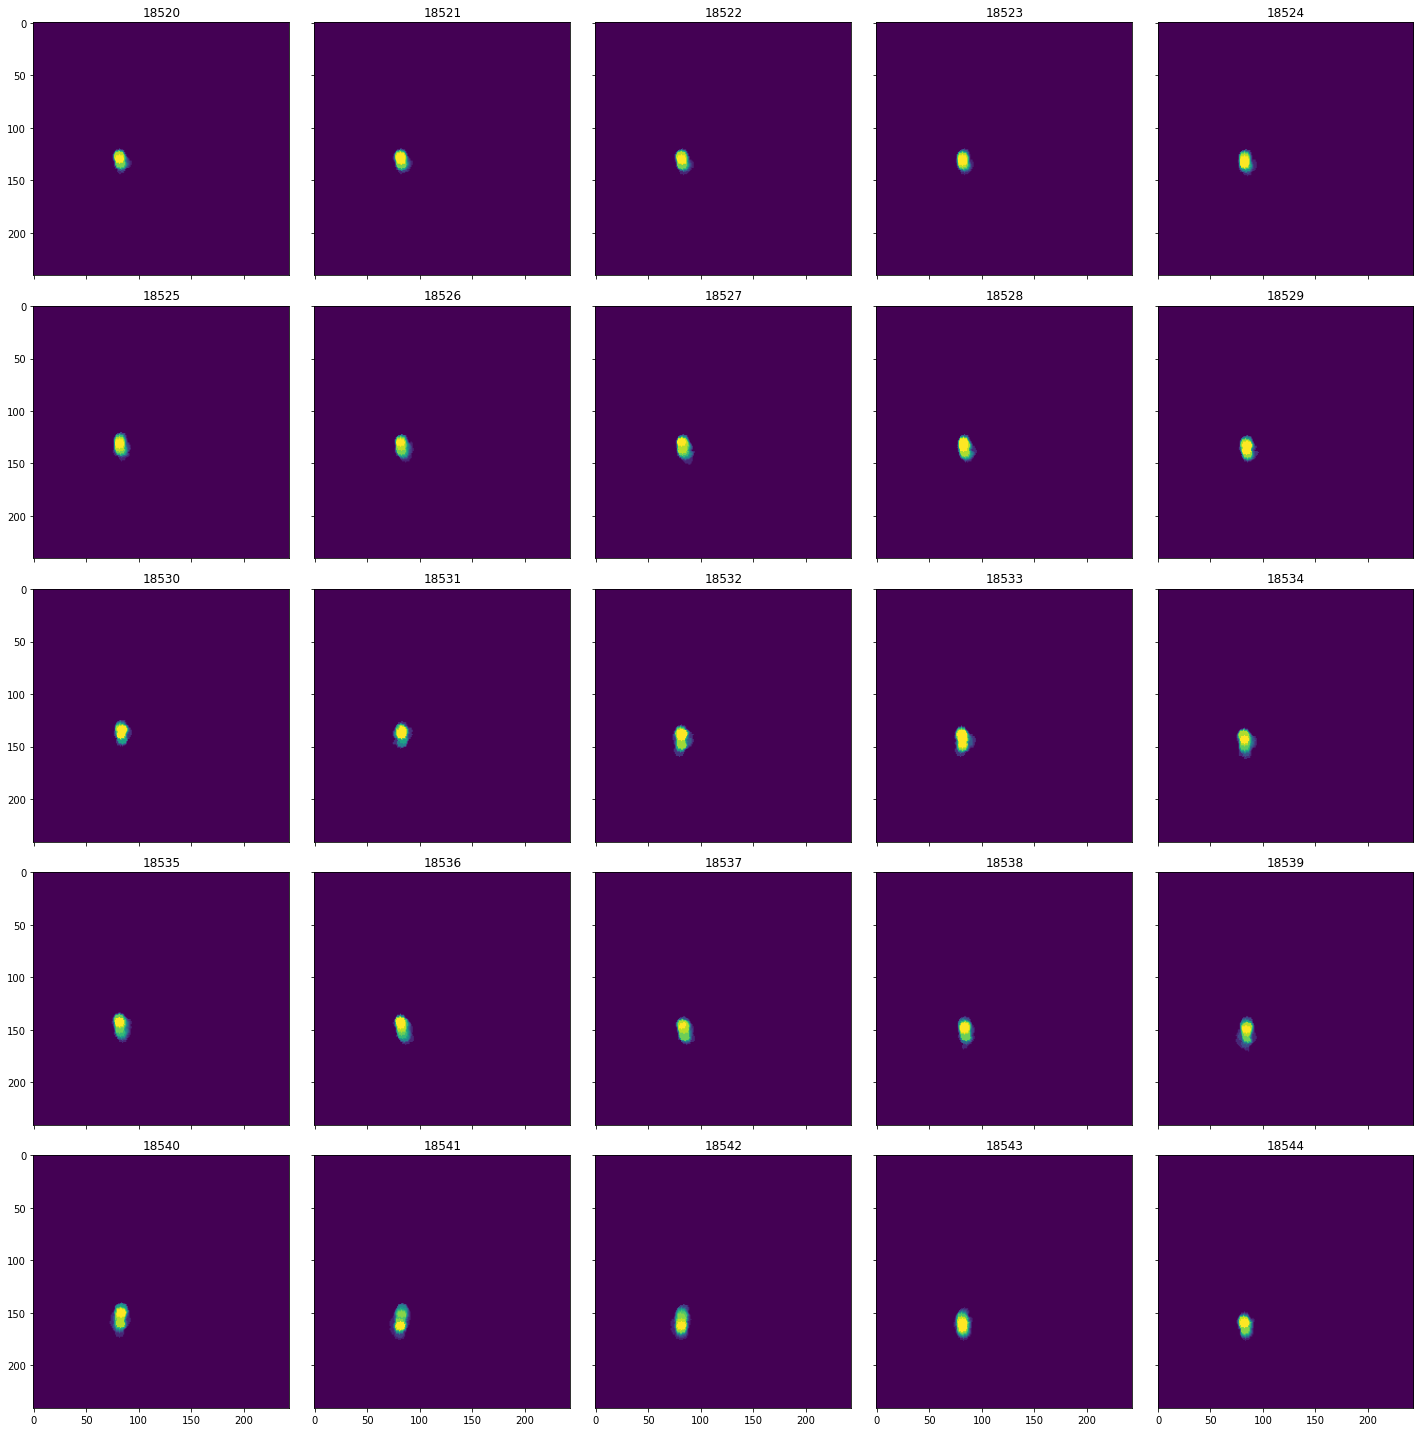

In [13]:
plot_frames(cleaned_frames, frame_idxs, vmin=None, vmax=None)

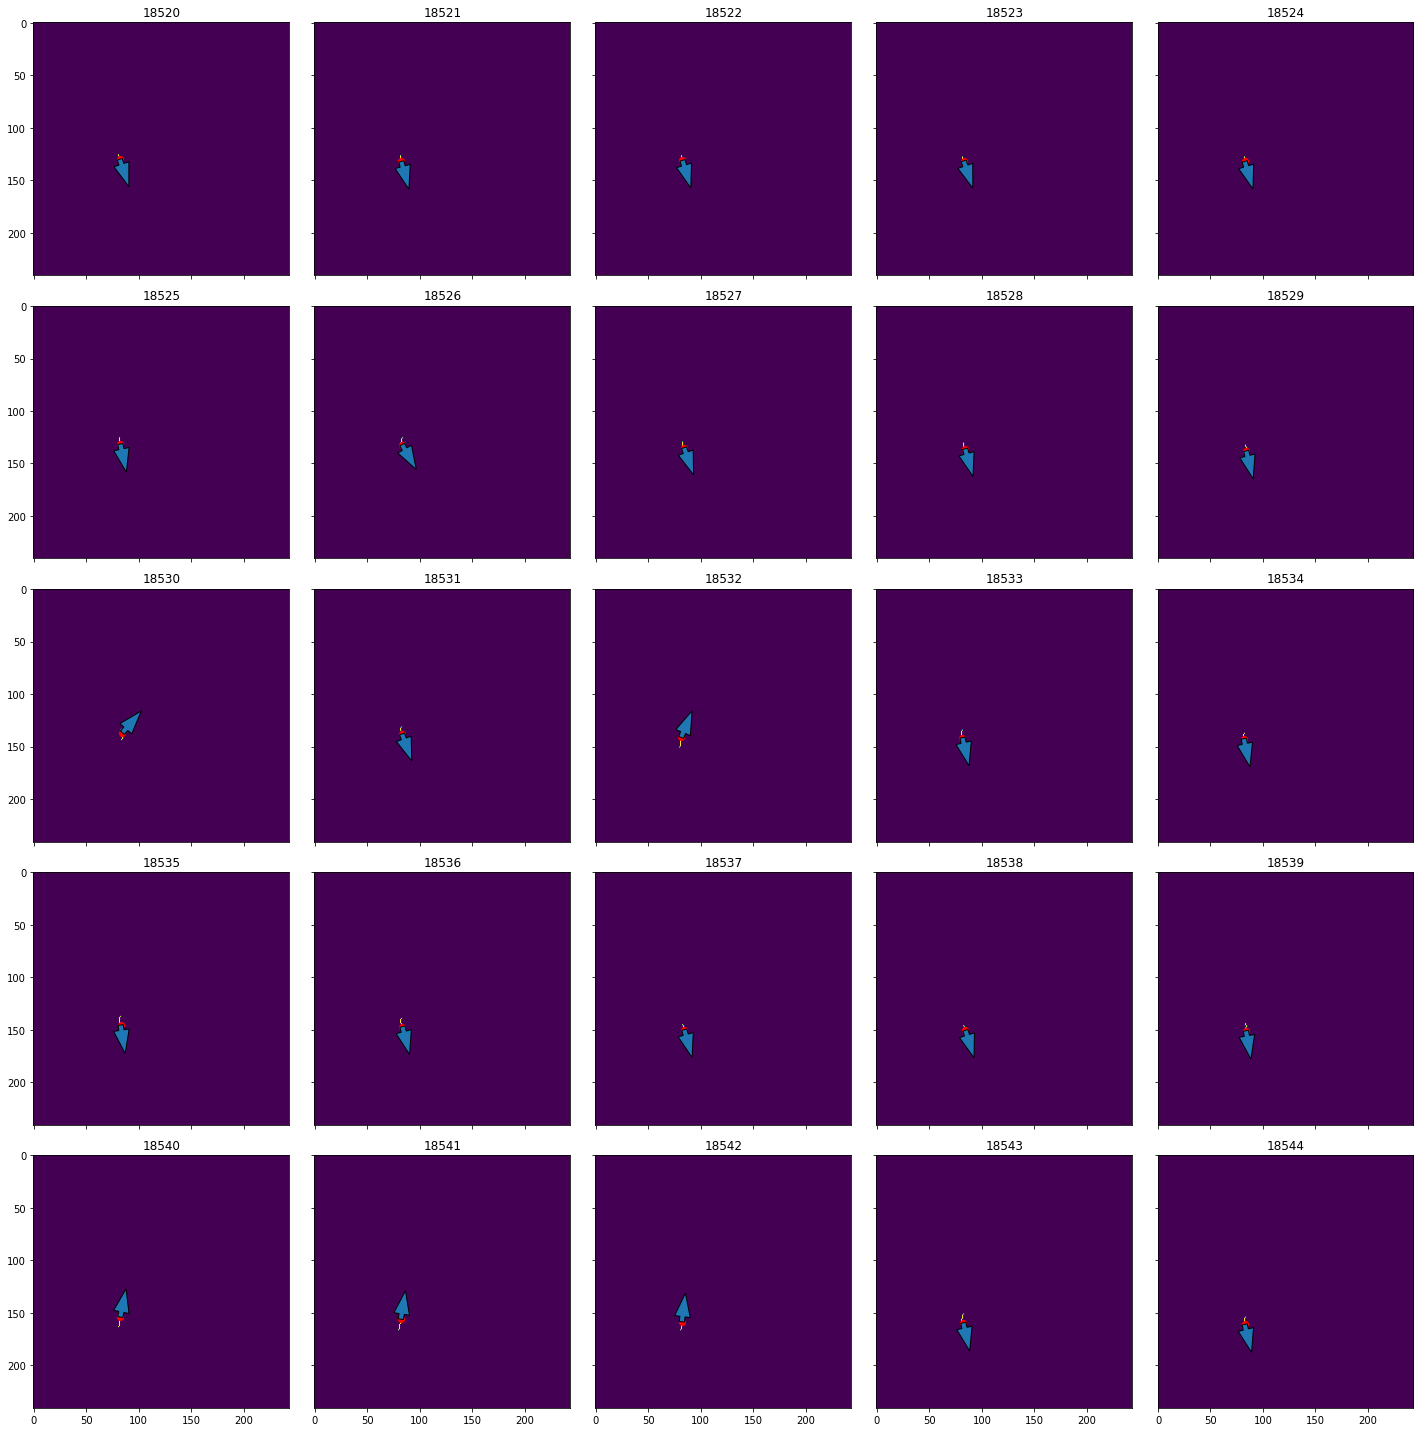

In [49]:
dist_frames = np.zeros_like(cleaned_frames)
feats = []
for i in range(masks.shape[0]):
    #dist_frames[i] = medial_axis(masks[i])
    dist_frames[i] = skeletonize(masks[i])
    feat = im_moment_features(dist_frames[i])
    feat['orientation'] = lin_regress_orientation(dist_frames[i])
    feats.append(feat)
    #dist_frames[i] = cv2.distanceTransform(cleaned_frames[i], distanceType=cv2.DIST_L2, maskSize=5)

plot_frames(dist_frames, frame_idxs, vmin=None, vmax=None, features=feats)

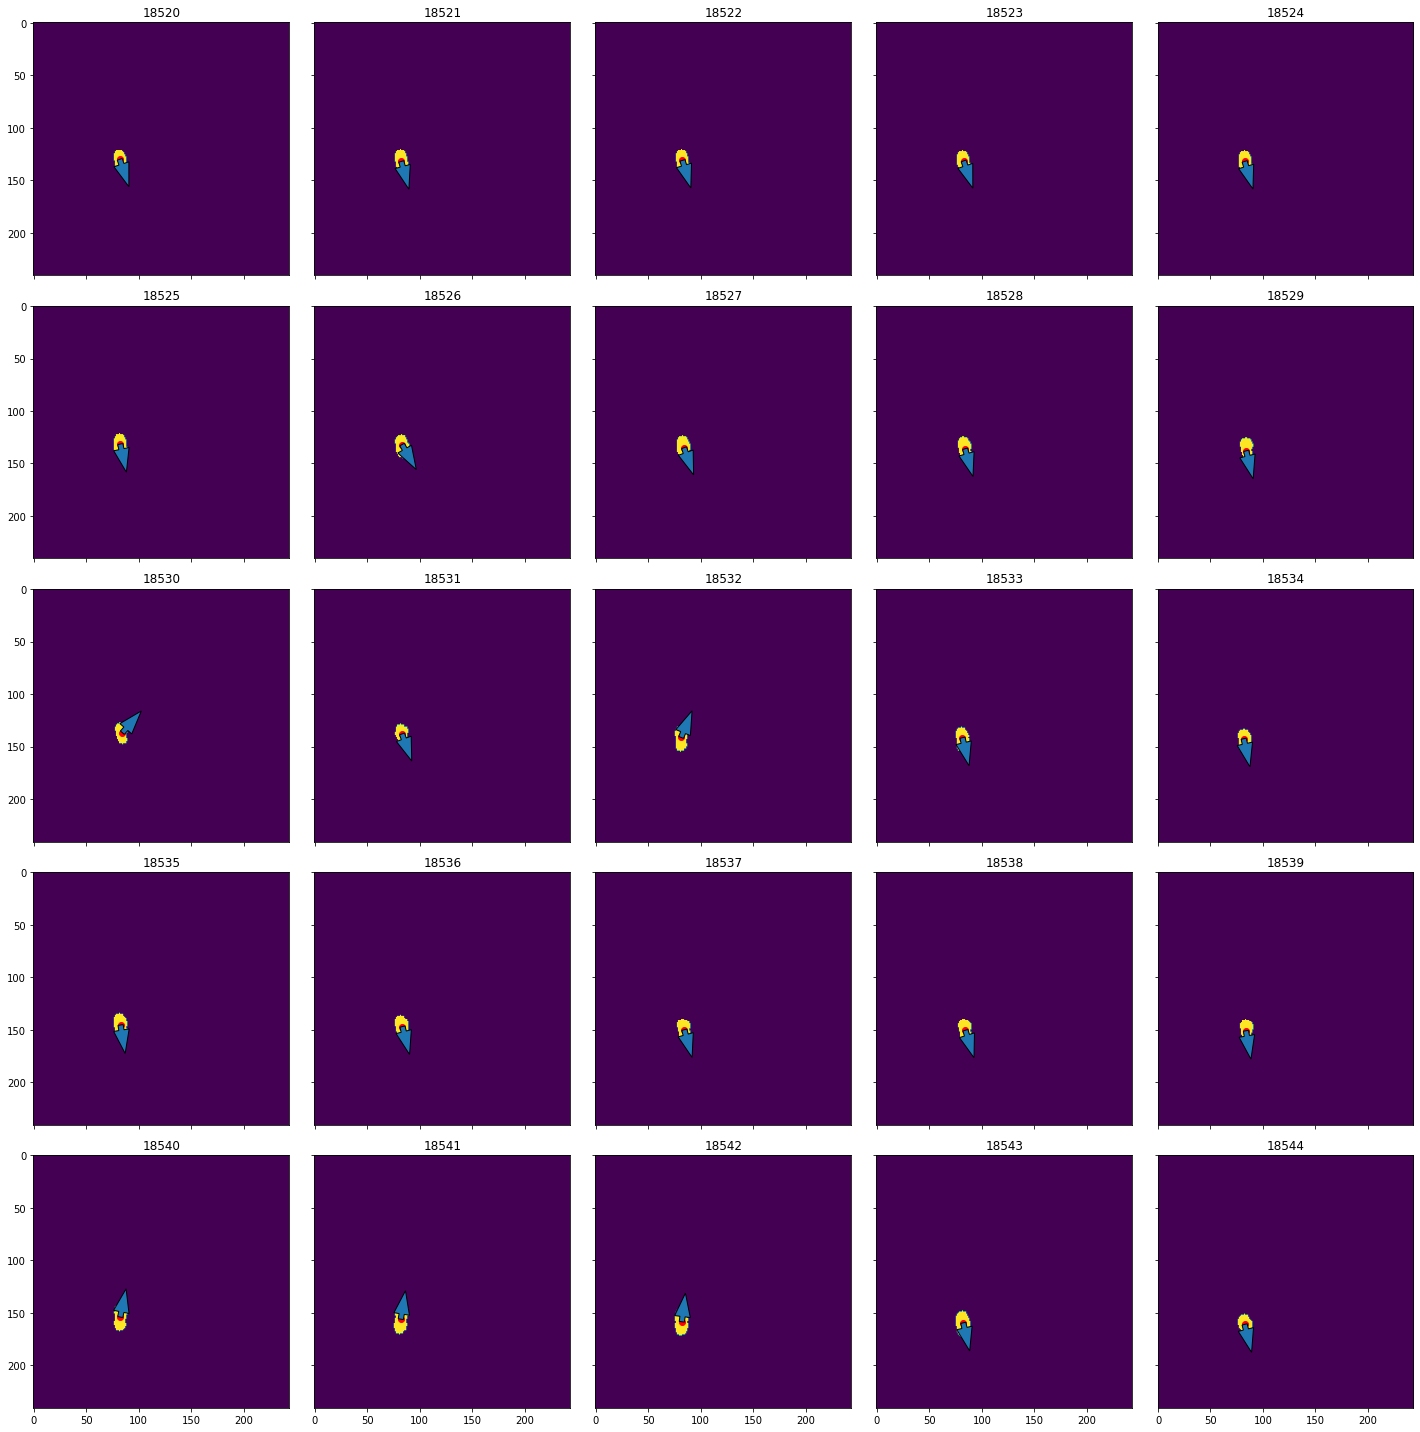

In [50]:
plot_frames(masks, frame_idxs, vmin=None, vmax=None, features=feats)

In [34]:
feats

[{'orientation': -1.3683504336523549,
  'centroid': [82.0, 130.0],
  'axis_length': [10.537812754158185, 1.6529610207378975]},
 {'orientation': -1.4786341223450292,
  'centroid': [82.45454545454545, 132.0],
  'axis_length': [12.70213956611319, 1.6194420618669345]},
 {'orientation': -1.3381763446235042,
  'centroid': [82.55555555555556, 131.0],
  'axis_length': [10.60957400418255, 1.2687706474949083]},
 {'orientation': -1.2993829198610012,
  'centroid': [82.625, 131.5],
  'axis_length': [9.507915080793735, 1.1617016899424355]},
 {'orientation': -1.3381763446235044,
  'centroid': [82.55555555555556, 132.0],
  'axis_length': [10.60957400418255, 1.268770647494913]},
 {'orientation': -1.4099210495965755,
  'centroid': [82.5, 131.5],
  'axis_length': [13.987250679761802, 1.3000583659345353]},
 {'orientation': -1.5143187331672825,
  'centroid': [83.15384615384616, 132.0],
  'axis_length': [14.989858199997483, 2.511984933020662]},
 {'orientation': -1.2674937724976332,
  'centroid': [84.0, 135.